In [2]:
%load_ext autoreload

In [15]:
%autoreload 2
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
import numpy as np
import os
import pandas as pd
import re
import scipy
from statsmodels.tsa.api import VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

sys.path.append('../../..')
from multiproc import compute_VAR
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Load Neural Data 

In [4]:
session = 'Mary-Anesthesia-20160912-02'

In [5]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [6]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [7]:
spike_times = spike_times[0]

# Load VAR Results

In [162]:
# VAR_results, window_selection_info = run_window_selection(session, return_data=True, verbose=False)

In [263]:
window = 4
results_dir = '/om/user/eisenaj/ChaoticConsciousness/results/propofolPuffTone/VAR'
VAR_results_folder = get_result_path(results_dir, session, window)
VAR_results = {}
for area in tqdm(os.listdir(VAR_results_folder)):
    VAR_results[area] = load(os.path.join(VAR_results_folder, area))

  0%|          | 0/5 [00:00<?, ?it/s]

# VAR(p)

In [264]:
def compute_VAR_p(window_data, unit_indices=None, p=1, PCA_dim=-1):
    if unit_indices is None:
        chunk = window_data
    else:
        chunk = window_data[:, unit_indices]
    k = chunk.shape[0]

    results = {}
    results['explained_variance'] = None
    if PCA_dim > 0:
        if PCA_dim < 2:
            raise ValueError(f"PCA dimension must be greater than 1; provided value was {PCA_dim}")
        pca = PCA(n_components=PCA_dim)
        chunk = pca.fit_transform(chunk)
        results['explained_variance'] = pca.explained_variance_ratio_
    
    model = VAR(chunk)
    VAR_results = model.fit(p)

    results['coefs'] = VAR_results.coefs
    results['intercept'] = VAR_results.intercept

    N = chunk.shape[1]
    A_mat = np.zeros((N*p, N*p))
    for i in range(p):
        A_mat[0:N][:, i*N:(i+1)*N] = VAR_results.coefs[i]

    for i in range(p - 1):
        A_mat[(i + 1)*N:(i + 2)*N][:, i*N:(i + 1)*N] = np.eye(N)
    e = np.linalg.eigvals(A_mat)   
    results['eigs'] = e  
    results['criticality_inds'] = np.abs(e)

    try:
        results['info_criteria'] = VAR_results.info_criteria
    except:
        results['info_criteria'] = None
    
#     results['sigma2_ML'] = np.linalg.norm(VAR_results.endog[1:] - (VAR_results.endog_lagged @ VAR_results.params), axis=1).sum()/(k - p - 1)
#     results['AIC'] = k*np.log(results['sigma2_ML']) + p + 1
#     results['sigma_norm'] = np.linalg.norm(VAR_results.sigma_u, ord=2)

    return results

In [285]:
np.argmax(VAR_results[area].start_time > session_info['eyesClose'])

371

In [286]:
area = 'all'
iloc_ind = 380
max_p = 15

if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

window_data = lfp[VAR_results[area].iloc[iloc_ind].start_ind:VAR_results[area].iloc[iloc_ind].end_ind]

VAR_p_rets = {}
for p in tqdm(range(1, max_p + 1)):
    VAR_p_rets[p] = compute_VAR_p(window_data, unit_indices, p)

  0%|          | 0/15 [00:00<?, ?it/s]

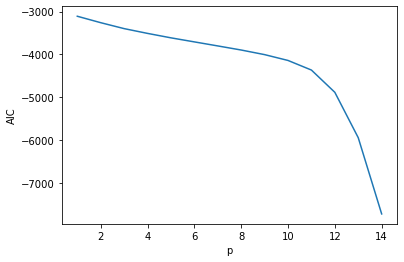

In [287]:
# AIC plot
aic_vals = [VAR_p_rets[p]['info_criteria']['aic'] for p in range(1, max_p + 1) if VAR_p_rets[p]['info_criteria'] is not None]
p_vals = [p for p in range(1, max_p + 1) if VAR_p_rets[p]['info_criteria'] is not None]
plt.plot(p_vals, aic_vals)
plt.xlabel('p')
plt.ylabel('AIC')
plt.show()

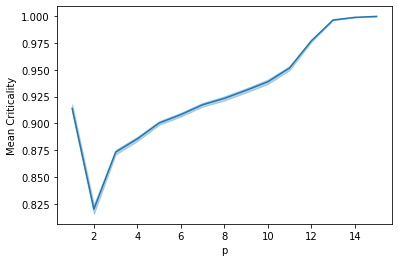

In [288]:
# criticality plot
mean_criticalities = np.array([VAR_p_rets[p]['criticality_inds'].mean() for p in range(1, max_p + 1)])
std_error_criticalities = np.array([VAR_p_rets[p]['criticality_inds'].std()/np.sqrt(len(VAR_p_rets[p]['criticality_inds'])) for p in range(1, max_p + 1)])
plt.plot(np.arange(1, max_p+1), mean_criticalities)
plt.fill_between(np.arange(1, max_p+1), mean_criticalities - std_error_criticalities, mean_criticalities + std_error_criticalities, alpha = 0.3, color='C0')
plt.xlabel('p')
plt.ylabel('Mean Criticality')
plt.show()

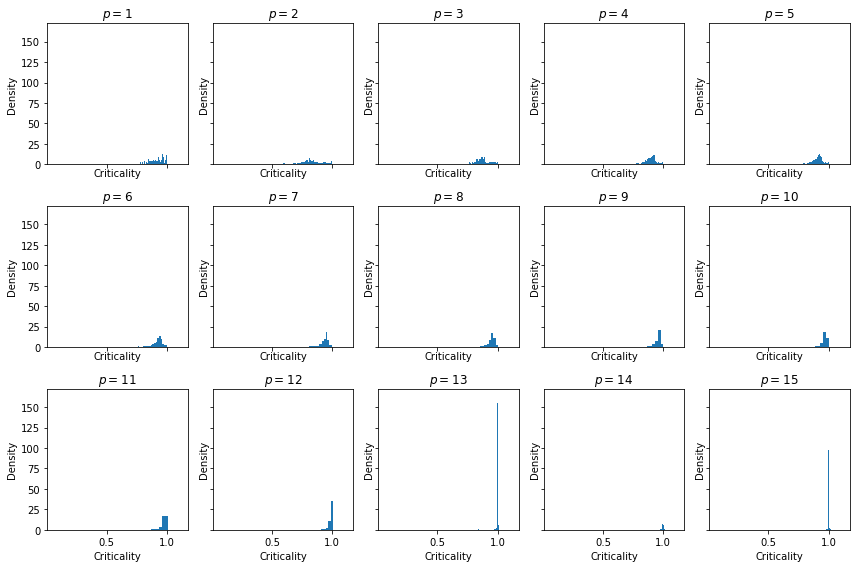

In [289]:
# criticality distributions
fig, axs = plt.subplots(3, 5, figsize=(12, 8), sharex=True, sharey=True)

for p in np.arange(1, max_p + 1):
    ax = axs[int((p - 1)/5)][(p - 1) % 5]
    ax.hist(VAR_p_rets[p]['criticality_inds'], bins=40, density=True)
    ax.set_title(r"$p = $" + f"{p}")
    ax.set_xlabel("Criticality")
    ax.set_ylabel("Density")
plt.tight_layout()
plt.show()

In [290]:
start_step = VAR_results[area].iloc[iloc_ind].start_ind
# window = VAR_results[area].iloc[iloc_ind].window

In [295]:
T_pred = 10
predictions = np.zeros((max_p, T_pred, len(unit_indices)))
true_vals = np.zeros((max_p, T_pred, len(unit_indices)))

for p in range(1, max_p + 1):
    for t in range(T_pred):
        predictions[p - 1, t] = VAR_p_rets[p]['intercept']
        for i in range(1, p + 1):
            predictions[p - 1, t] += VAR_p_rets[p]['coefs'][i - 1] @ lfp[start_step + int(window/dt) + t - i, unit_indices]

    true_vals[p - 1] = lfp[start_step + int(window/dt):start_step + int(window/dt) + T_pred, unit_indices]

In [296]:
p_mses = ((predictions - true_vals)**2).mean(axis=2).mean(axis=1)
p_mse_std_error = ((predictions - true_vals)**2).reshape((max_p, T_pred*len(unit_indices))).std(axis=1)/np.sqrt(T_pred*len(unit_indices))
persistence_baseline = ((lfp[start_step + int(window/dt):start_step + int(window/dt) + T_pred, unit_indices] - lfp[start_step + int(window/dt) - 1:start_step + int(window/dt) + T_pred - 1, unit_indices])**2).mean()

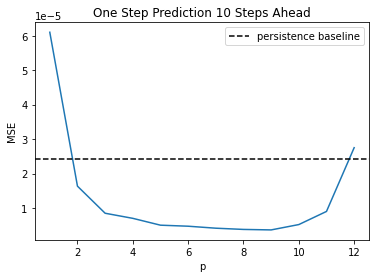

In [297]:
plt.plot(np.arange(1, max_p + 1)[:12], p_mses[:12])
# plt.fill_between(np.arange(1, max_p + 1), p_mses - p_mse_std_error, p_mses + p_mse_std_error, alpha=0.4, color='C0')
plt.axhline(persistence_baseline, c = 'k', linestyle='--', label='persistence baseline')
plt.title(f"One Step Prediction {T_pred} Steps Ahead")
plt.xlabel("p")
plt.ylabel("MSE")
plt.legend()
plt.show()

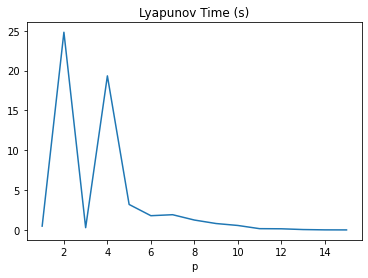

In [298]:
# lyapunov time
plt.plot(np.arange(1, max_p + 1)[:15], [dt/np.abs(np.log(VAR_p_rets[p]['criticality_inds'].max())) for p in range(1, max_p + 1)][:15])
plt.title('Lyapunov Time (s)')
plt.xlabel('p')
plt.show()

In [280]:
wakeful = VAR_p_rets.copy() # 6 - 8

In [299]:
anesthesia = VAR_p_rets.copy() # 6 - 8

In [303]:
anesthesia[8]['criticality_inds'].mean()

0.9232903117620601

In [304]:
wakeful[8]['criticality_inds'].mean()

0.9229015513659158

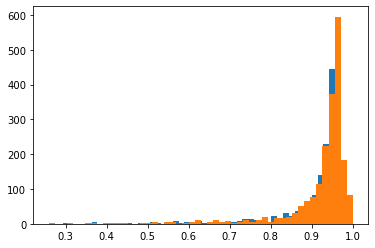

In [302]:
plt.hist(wakeful[8]['criticality_inds'], bins=50)
plt.hist(anesthesia[8]['criticality_inds'], bins=50)
plt.show()

In [199]:
# # CHAINED PREDICTION
# T_pred = 10
# predictions = np.zeros((max_p, T_pred, len(unit_indices)))
# true_vals = np.zeros((max_p, T_pred, len(unit_indices)))

# for p in range(1, max_p + 1):
#     for t in range(T_pred):
#         predictions[p - 1, t] = VAR_p_rets[p]['intercept']
#         for i in range(1, p + 1):
# #             print(f"t = {t}, i = {i}")
#             if i - 1 < t:
# #                 print("up")
#                 predictions[p - 1, t] += VAR_p_rets[p]['coefs'][i - 1] @ predictions[p - 1, t - i]
#             else:
# #                 print("down")
#                 predictions[p - 1, t] += VAR_p_rets[p]['coefs'][i - 1] @ lfp[start_step + int(window/dt) + t - i, unit_indices]

#     true_vals[p - 1] = lfp[start_step + int(window/dt):start_step + int(window/dt) + T_pred, unit_indices]

In [200]:
# p_mses = ((predictions - true_vals)**2).mean(axis=2).mean(axis=1)
# # persistence_baseline = ((lfp[start_step + int(window/dt):start_step + int(window/dt) + T_pred, unit_indices] - lfp[start_step + int(window/dt) - 1:start_step + int(window/dt) + T_pred - 1, unit_indices])**2).mean()
# plt.plot(np.arange(1, max_p + 1), p_mses)
# # plt.axhline(persistence_baseline, c = 'k', linestyle='--', label='persistence baseline')
# plt.title(f"Chained Prediction {T_pred} Steps Ahead")
# plt.xlabel("p")
# plt.ylabel("MSE")
# # plt.legend()
# plt.show()

# Whole Session?

In [343]:
window = 4
stride = window
area = 'all'
p = 8

if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

In [344]:
num_windows = int(np.floor((T-int(window/dt))/int(stride/dt))+1)

In [321]:
VAR_result_dicts = []
for i in tqdm(range(num_windows)):
    window_data = lfp[i*int(stride/dt):(i + 1)*int(stride/dt) + int(window/dt)]
    ret = compute_VAR_p(window_data, unit_indices, p)
    ret['start_time'] = i*stride
    ret['start_ind'] = i*int(stride/dt)
    ret['end_time'] = i*stride + window
    ret['end_ind'] = (i + 1)*int(stride/dt) + int(window/dt)
    ret['p'] = p
    ret['window'] = window
    
    VAR_result_dicts.append(ret) 

  0%|          | 0/1626 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
VAR_results = pd.DataFrame(VAR_result_dicts)

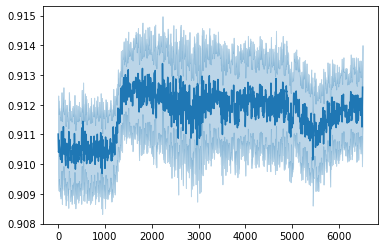

In [323]:
means = VAR_results.criticality_inds.apply(lambda x: x.mean())
std_error = VAR_results.criticality_inds.apply(lambda x: x.std()/np.sqrt(len(x)))
time = VAR_results.start_time
std_error
plt.plot(time, means)
plt.fill_between(time, means - std_error, means + std_error, color='C0', alpha=0.3)
plt.show()

In [324]:
eyes_close = session_info['eyesClose'][1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [337]:
wake_inds = np.hstack(VAR_results.criticality_inds[VAR_results.start_time < session_info['drugStart'][0]].to_numpy())
anesthesia_inds = np.hstack(VAR_results.criticality_inds[np.logical_and(VAR_results.start_time < session_info['drugEnd'][1], VAR_results.start_time > eyes_close)].to_numpy())

In [342]:
scipy.stats.mannwhitneyu(wake_inds, anesthesia_inds, alternative='less')

MannwhitneyuResult(statistic=29487138904.0, pvalue=3.644697618924181e-169)

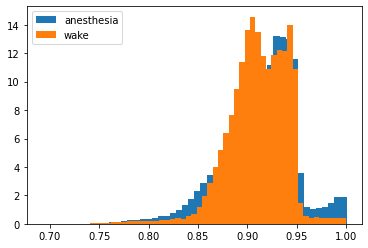

In [351]:
plt.hist(anesthesia_inds, bins=50, density=True, label='anesthesia')
plt.hist(wake_inds, bins=50, density=True, label='wake')
plt.legend()
plt.show()

In [367]:
def qqplot(x, y, num_quantiles=100):
    x_sorted = np.sort(x)
    y_sorted = np.sort(y)
    
    x_quantiles = np.zeros(num_quantiles + 1)
    y_quantiles = np.zeros(num_quantiles + 1)
    
    for quantile in np.arange(num_quantiles + 1):
        x_quantiles[quantile] = x_sorted[int((quantile/(num_quantiles))*(len(x) - 1))]
        y_quantiles[quantile] = y_sorted[int((quantile/(num_quantiles))*(len(y)-1))]
    
    plt.scatter(x_quantiles, y_quantiles)
    plt.plot(np.linspace(x_quantiles[0], x_quantiles[-1], 1000), np.linspace(y_quantiles[0], y_quantiles[-1], 1000), c='k', linestyle='--')
    
    plt.xlabel('Wakeful Inds')
    plt.ylabel('Anesthesia Inds')
    plt.title('QQ Plot')
    
    plt.show()

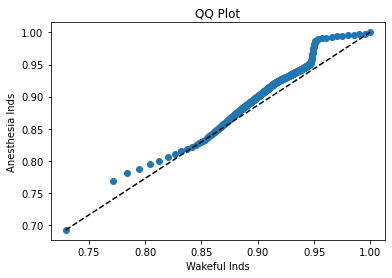

In [368]:
qqplot(wake_inds, anesthesia_inds, 500)

In [381]:
num_bins = 50
hists = np.zeros((len(VAR_results), num_bins))
bin_edges = np.linspace(min_val, max_val, num_bins + 1)
for i, row in VAR_results.iterrows():
    hists[i] = np.histogram(row.criticality_inds, bin_edges)[0]

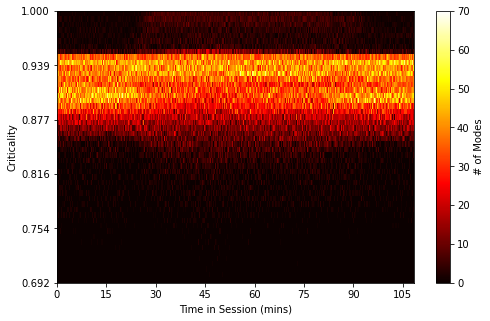

In [407]:
plt.figure(figsize=(8, 5))
plt.pcolormesh(hists.T, cmap='hot')
plt.yticks(np.arange(0, 51, 10), [f"{val:.3f}" for val in bin_edges[np.arange(0, 51, 10)]])
plt.xticks(np.arange(0, T*dt/60, 15)*60/window, [int(val) for val in np.arange(0, T*dt/60, 15)])
plt.xlabel('Time in Session (mins)')
plt.ylabel("Criticality")
plt.colorbar(label='# of Modes')
plt.show()

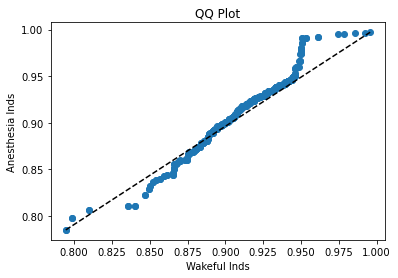

In [416]:
qqplot(VAR_results.iloc[5].criticality_inds, VAR_results.iloc[803].criticality_inds, 500)